In [ ]:
import torch
from utils import  JSONDataset, RevdictModel, PAD, EOS, BOS, UNK, AraT5RevDict
import tqdm # progree bar

In [ ]:
# Step 1: Prepare the Dataset
dataset_file = 'dev.json'  # Replace with your dataset file path
dataset = JSONDataset(dataset_file)

In [1]:
print(dataset.tensors)

tensor([[ 0.2266, -0.3225,  0.5538,  ..., -0.6223,  0.2661, -0.5677],
        [ 0.1077, -0.0218, -0.3933,  ...,  0.4063,  0.5363,  0.1220],
        [ 0.6839, -0.0343,  0.5486,  ..., -0.1558,  0.8715,  0.1370],
        ...,
        [-0.9649, -0.0455,  0.6362,  ...,  0.3220,  0.3221,  1.0571],
        [-0.2101, -0.3290, -0.5636,  ..., -0.6032,  0.2019, -0.2902],
        [-0.1904,  0.0340,  0.1342,  ..., -1.0300, -0.3537, -0.8930]])


In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100])
# print(dataset.vocab)
# Step 2: Model Selection
model = RevdictModel(dataset.vocab, d_model=256, n_head=4, n_layers=4, dropout=0.3, maxlen=256)

In [2]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The RevdictModel model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RevdictModel model has 51 different named parameters.

==== Embedding Layer ====

embedding.weight                                        (15210, 256)
transformer_encoder.layers.0.self_attn.in_proj_weight     (768, 256)
transformer_encoder.layers.0.self_attn.in_proj_bias           (768,)
transformer_encoder.layers.0.self_attn.out_proj.weight    (256, 256)
transformer_encoder.layers.0.self_attn.out_proj.bias          (256,)

==== First Transformer ====

transformer_encoder.layers.0.linear1.weight               (512, 256)
transformer_encoder.layers.0.linear1.bias                     (512,)
transformer_encoder.layers.0.linear2.weight               (256, 512)
transformer_encoder.layers.0.linear2.bias                     (256,)
transformer_encoder.layers.0.norm1.weight                     (256,)
transformer_encoder.layers.0.norm1.bias                       (256,)
transformer_encoder.layers.0.norm2.weight                     (256,)
transformer_encoder.layers.0.norm2.bias                 

In [ ]:
# Hayper
EPOCHS, LEARNING_RATE, BETA1, BETA2, WEIGHT_DECAY = 10, 1.0e-4, 0.9, 0.999, 1.0e-6
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        betas=(BETA1, BETA2),
        weight_decay=WEIGHT_DECAY,
)
loss_fn = torch.nn.MSELoss()

In [3]:
# Step 3: Model Training
for epoch in tqdm.trange(EPOCHS, desc="Epoch"):  
    model.train()
    for batch in train_set:

        gloss_tensor = batch['gloss_tensor'].unsqueeze(1)
        gloss_emb = batch['electra_tensor'].unsqueeze(1)  # Choose one of the embeddings (bertseg, bertmsa, electra)
        # print(gloss_emb.size(), gloss_tensor.size())
        # break
        optimizer.zero_grad()
        output_emb = model(gloss_tensor)
        loss = loss_fn(output_emb, gloss_emb)
        loss.backward()
        optimizer.step()

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
Cell In[23], line 14
     12 loss = loss_fn(output_emb, gloss_emb)
     13 loss.backward()
---> 14 optimizer.step()

File ~/.local/lib/python3.12/site-packages/torch/optim/optimizer.py:391, in Optimizer.profile_hook_step.<locals>.wrapper(*args, **kwargs)
    386         else:
    387             raise RuntimeError(
    388                 f"{func} must return None or a tuple of (new_args, new_kwargs), but got {result}."
    389             )
--> 391 out = func(*args, **kwargs)
    392 self._optimizer_step_code()
    394 # call optimizer step post hooks

File ~/.local/lib/python3.12/site-packages/torch/optim/optimizer.py:76, in _use_grad_for_differentiable.<locals>._use_grad(self, *args, **kwargs)
     74     torch.set_grad_enabled(self.defaults['differentiable'])
     75     torch._dynamo.graph_break()
---> 76     ret = func(self, *args

In [4]:
# Step 4: Model Evaluation
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in test_set:
        gloss_tensor = batch['gloss_tensor'].unsqueeze(1)
        gloss_emb = batch['electra_tensor'].unsqueeze(1)
        # print(gloss_tensor)
        output_emb = model(gloss_tensor)
        loss = loss_fn(output_emb, gloss_emb)
        total_loss += loss.item()

avg_loss = total_loss / len(test_set)
print(f"Average Test Loss: {avg_loss:.4f}")

Average Test Loss: 0.3214


In [5]:
# embedding_list=[data["electra_tensor"] for data in dataset]
# print(embedding_list[0])

tensor([ 0.2266, -0.3225,  0.5538,  0.5800, -0.0343, -0.0777,  0.2868,  0.6898,
         0.5972,  0.4829,  0.0247,  0.2119,  0.0674,  0.3009, -0.8414, -0.0168,
         0.2171,  0.5730, -0.1634, -0.3821,  0.5487, -0.7530,  0.6815,  0.6415,
         0.4434, -0.6304,  0.4416,  0.0700,  1.3176, -0.3286,  0.2451, -0.0553,
         0.4971, -0.4185,  0.5858, -0.0440,  1.3485, -0.9497,  0.1511,  0.2152,
        -0.4864,  0.3028, -0.0959, -0.0409, -0.8453, -0.1001, -0.4719, -0.0784,
         0.7887, -0.1880,  0.2889,  1.1853,  0.5521, -0.8278,  0.6820, -0.2602,
         0.1381,  0.1392,  0.0436, -0.4878, -0.0483, -0.2761,  0.4850, -0.4399,
        -0.0801,  0.0903,  0.0118,  0.3186, -0.6859, -0.5259,  0.0464, -0.3840,
         1.0247,  0.8888, -0.7507, -1.1357, -0.3238, -0.0270, -0.7847, -1.0209,
         0.5859, -0.8039,  0.2843, -0.5100,  0.7754,  1.1104, -0.6913,  0.5530,
         0.1032,  0.5610,  1.0204, -0.7724,  0.4081, -0.7806, -0.6322, -0.2794,
         0.8085,  0.2857,  0.5467,  1.03

In [6]:
# Assuming 'model' is your trained model
model.vocab = dataset.vocab
# dataset.tensors = embedding_list

freeze_vocab=0
maxlen = 256
# Step 5: Reverse Dictionary Lookup
def find_similar_words(gloss, n=5):
    with torch.no_grad():
        # if gloss not in model.vocab:
        #     print(f"Gloss '{gloss}' is not in the vocabulary.")
            # return []
        # gloss_tensor = torch.tensor(model.vocab[gloss])
        # gloss_tensor = torch.clamp(gloss_tensor, min=0, max=model.embedding.num_embeddings - 1)
        # gloss_tensor = model.embedding(gloss_tensor)
        gloss_tensor= torch.tensor(
                [model.vocab[PAD]] + [
                    model.vocab[word]
                    if not freeze_vocab
                    else dataset.vocab.get(word, model.vocab[UNK])
                    for word in gloss.split()
                ]
                + [model.vocab[EOS]])

        if maxlen:
            gloss_tensor = gloss_tensor[:maxlen]

        gloss_emb = model(gloss_tensor.unsqueeze(1))
        distances = torch.cdist(gloss_emb, dataset.tensors, p=2)
        closest_indices = torch.topk(distances, n, largest=False).indices
        closest_words = [dataset.itos[idx] for idx in closest_indices.squeeze()]

        # print("Size of the vocabulary:", len(model.vocab))
        # print("Index being passed to embedding layer:", model.vocab[gloss])
        return closest_words

query_gloss = "غَمَّ وَأَمْرَضَ القَلْبَ"  # Replace with your query gloss
# query_gloss = dev_df.loc[0,"gloss"]
similar_words = find_similar_words(query_gloss)
if similar_words:
    print(f"Similar words for '{query_gloss}': {similar_words}")
else:
    print(f"No similar words found for '{query_gloss}'.")

Similar words for 'غَمَّ وَأَمْرَضَ القَلْبَ': ['العميد', 'لم', 'باخرة', 'المبدوءة', 'الطَّعام']


In [7]:
import pandas as pd
dev_df=pd.read_json("dev.json")
print(dev_df.info())
print(dev_df.loc[1,"gloss"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3921 non-null   object
 1   word     3921 non-null   object
 2   pos      3636 non-null   object
 3   gloss    3921 non-null   object
 4   electra  3921 non-null   object
 5   bertseg  3921 non-null   object
 6   bertmsa  3921 non-null   object
dtypes: object(7)
memory usage: 214.6+ KB
None
حرف جرّ زائد في التوكيد بالنفس والعين .


In [8]:
# Assuming 'model' is your trained model
model.vocab = dataset.vocab
dataset.tensors = embedding_list

freeze_vocab=0
maxlen = 256
# Step 5: Reverse Dictionary Lookup
def find_similar_words(gloss, n=5):
    with torch.no_grad():
        # if gloss not in model.vocab:
        #     print(f"Gloss '{gloss}' is not in the vocabulary.")
            # return []
        # gloss_tensor = torch.tensor(model.vocab[gloss])
        # gloss_tensor = torch.clamp(gloss_tensor, min=0, max=model.embedding.num_embeddings - 1)
        # gloss_tensor = model.embedding(gloss_tensor)
        gloss_tensor= torch.tensor(
                [model.vocab[PAD]] + [
                    model.vocab[word]
                    if not freeze_vocab
                    else dataset.vocab.get(word, model.vocab[UNK])
                    for word in gloss.split()
                ]
                + [model.vocab[EOS]])

        if maxlen:
            gloss_tensor = gloss_tensor[:maxlen]

        gloss_emb = model(gloss_tensor.unsqueeze(1))
        dataset_tensor = dataset.tensors[0].unsqueeze(1)
        distances = torch.cdist(gloss_emb, dataset_tensor, p=2)
        closest_indices = torch.topk(distances, n, largest=False).indices
        closest_words = [dataset.itos[idx] for idx in closest_indices.squeeze()]

        # print("Size of the vocabulary:", len(model.vocab))
        # print("Index being passed to embedding layer:", model.vocab[gloss])
        return closest_words

# query_gloss = "غَمَّ وَأَمْرَضَ القَلْبَ"  # Replace with your query gloss
query_gloss = dev_df.loc[1,"gloss"]
similar_words = find_similar_words(query_gloss)
if similar_words:
    print(f"Similar words for '{query_gloss}': {similar_words}")
else:
    print(f"No similar words found for '{query_gloss}'.")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[8], line 2
      1 # Assuming 'model' is your trained model
----> 2 model.vocab = dataset.vocab
      3 dataset.tensors = embedding_list
      5 freeze_vocab=0

NameError: name 'dataset' is not defined


In [ ]:
# [*map(lambda x:x[0], embeddings_df.values)]

In [9]:
import pandas as pd
dev_df = pd.read_json("dev.json")

print(dev_df.info())
print(dev_df.set_index("word"))
# print(dev_df.loc[0,["word", "gloss"]])
# dev_df.loc[0,"electra"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3921 non-null   object
 1   word     3921 non-null   object
 2   pos      3636 non-null   object
 3   gloss    3921 non-null   object
 4   electra  3921 non-null   object
 5   bertseg  3921 non-null   object
 6   bertmsa  3921 non-null   object
dtypes: object(7)
memory usage: 214.6+ KB
None
                           id  ...                                            bertmsa
word                           ...                                                   
أَكْمَدَ            ar.962714  ...  [-1.0540555716, 0.7359393239, -0.4855850637000...
ب                   ar.994971  ...  [-0.8878438473, 1.0998017788, 1.085614562, 1.3...
ذَكَا               ar.989034  ...  [-1.9565393925, 1.2845952511, 0.3016183376, 0....
وَرَع               ar.994539  ...  [0.3653689027, 1.1957067251, -0.0340094306, 0...

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the word embeddings (assuming they are in a DataFrame)
# embeddings_df = pd.read_json("dev.json")
embeddings_df = pd.read_json("train.json")

# print(embeddings_df.columns)
# Drop unnecessary columns and set the word as the index
embeddings_df = embeddings_df.set_index("word").drop(["id", "pos", "gloss", "bertseg", "bertmsa"], axis=1)

# print(embeddings_df.dtypes)
# print(embeddings_df.iloc[0,0])
# print()
x = [*map(lambda x:x[0], embeddings_df.values)]
len(x)

31372

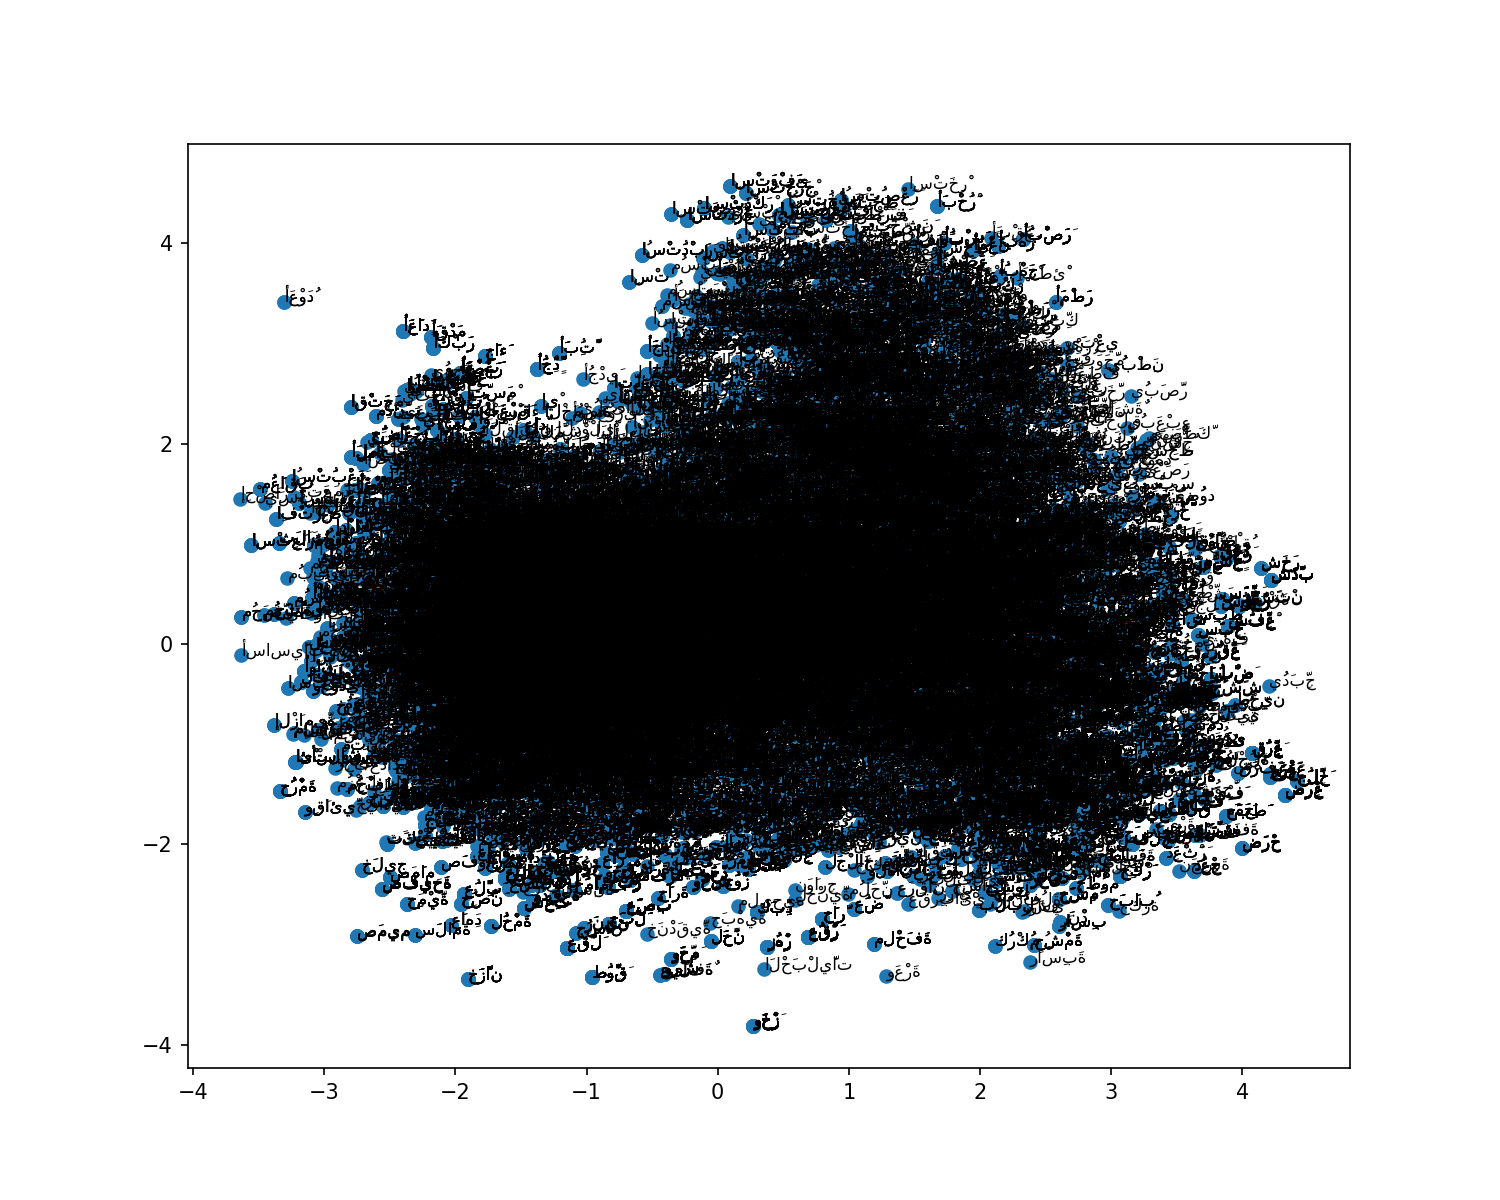

In [11]:
# # Perform PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform([*map(lambda x:x[0], embeddings_df.values)])

# # Create a new DataFrame with the reduced embeddings
reduced_df = pd.DataFrame(reduced_embeddings, index=embeddings_df.index, columns=["x", "y"])

# Plot the word embeddings using a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_df["x"], reduced_df["y"])

# # Add labels for the words (you can adjust the font size as needed)
for word, pos in reduced_df.iterrows():
    plt.text(pos.x, pos.y, word, fontsize=8)

 # plt.xlabel("PCA Dimension 1")
 # plt.ylabel("PCA Dimension 2")
 # plt.title("Word Embedding Visualization using PCA")
 # plt.grid(True)
 # plt.show()

# revdict5

In [ ]:
import argparse
import itertools
import json
import logging
import pathlib
import sys

from utils import  JSONDataset, RevdictModel, PAD, EOS, BOS, UNK, AraT5RevDict

logger = logging.getLogger(pathlib.Path("x.log").name)
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(
    logging.Formatter("%(asctime)s [%(levelname)s] %(name)s: %(message)s")
)
logger.addHandler(handler)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

import tqdm

# import data
# import models

from transformers import AutoTokenizer
# from ard_dataset import 

In [ ]:
def read_json(path):
    with open(path, 'r', encoding='utf-8') as fin:
        data = json.load(fin)
    return data

def write_json(path, data):
    with open(path, 'w', encoding='utf-8') as fout:
        json.dump(data, fout)


class ARDDataset(Dataset):
    def __init__(self, path, is_test=False) -> None:
        super().__init__()
        self.is_test = is_test
        self.data = read_json(path)

    def __getitem__(self, index):
        sample = self.data[index]
        if self.is_test:
            return sample["id"], sample["word"], sample["gloss"],
        else:
            return sample["id"], sample["word"], sample["gloss"], sample["electra"], sample["bertseg"], sample['bertmsa']

    def __len__(self):
        return len(self.data)

In [ ]:
def rank_cosine(preds, targets):
    assocs = F.normalize(preds) @ F.normalize(targets).T
    refs = torch.diagonal(assocs, 0).unsqueeze(1)
    ranks = (assocs >= refs).sum(1).float()
    assert ranks.numel() == preds.size(0)
    ranks = ranks.mean().item()
    return ranks / preds.size(0)

In [ ]:
def train(args):
    assert args.train_file is not None, "Missing dataset for training"
    # 1. get data, vocabulary, summary writer
    logger.debug("Preloading data")
    ## make datasets
    train_dataset = ARDDataset(args.train_file)
    valid_dataset = ARDDataset(args.dev_file)
    
    ## make dataloader
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size)
    valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size)
    ## make summary writer
    summary_writer = SummaryWriter(args.save_dir / args.summary_logdir)
    train_step = itertools.count()  # to keep track of the training steps for logging

    # 2. construct model
    ## Hyperparams
    logger.debug("Setting up training environment")

    model = AraT5RevDict(args).to(args.device)

    tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/AraT5v2-base-1024")     
    model.train()

    # 3. declare optimizer & loss_fn
    ## Hyperparams
    EPOCHS, LEARNING_RATE, BETA1, BETA2, WEIGHT_DECAY = 20, 1.0e-4, 0.9, 0.999, 1.0e-6
    optimizer = optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        betas=(BETA1, BETA2),
        weight_decay=WEIGHT_DECAY,
    )

    loss_fn = nn.MSELoss()

    vec_tensor_key = f"{args.target_arch}_tensor"

    best_cosine = 0

    # 4. train model
    for epoch in tqdm.trange(EPOCHS, desc="Epochs"):
        ## train loop
        pbar = tqdm.tqdm(
            desc=f"Train {epoch}", total=len(train_dataset), disable=None, leave=False
        )
        for ids, word, gloss, electra, bertseg, bertmsa in train_dataloader:
            optimizer.zero_grad()

            word_tokens = tokenizer(word, padding=True, return_tensors='pt').to(args.device)
            gloss_tokens = tokenizer(gloss, padding=True, return_tensors='pt').to(args.device)

            if args.target_arch == "electra":
                target_embs = torch.stack(electra, dim=1).to(args.device)
            elif args.target_arch =="bertseg":
                target_embs = torch.stack(bertseg, dim=1).to(args.device)
            elif args.target_arch =="bertmsa":
                target_embs = torch.stack(bertmsa, dim=1).to(args.device)


            target_embs = target_embs.float()
            ce_loss, pred_embs = model(
                gloss_tokens["input_ids"], 
                gloss_tokens["attention_mask"],
                word_tokens["input_ids"],
            )

            mse_loss = loss_fn(pred_embs, target_embs)
            loss = args.ce_loss_weight * ce_loss + mse_loss
            loss.backward()

            # keep track of the train loss for this step
            next_step = next(train_step)
            summary_writer.add_scalar(
                "revdict-train/cos",
                F.cosine_similarity(pred_embs, target_embs).mean().item(),
                next_step,
            )
            summary_writer.add_scalar("revdict-train/mse", mse_loss.item(), next_step)
            optimizer.step()
            pbar.update(target_embs.size(0))

        pbar.close()
        ## eval loop
        if args.dev_file:
            model.eval()
            with torch.no_grad():
                sum_dev_loss, sum_cosine, sum_rnk = 0.0, 0.0, 0.0
                pbar = tqdm.tqdm(
                    desc=f"Eval {epoch}",
                    total=len(valid_dataset),
                    disable=None,
                    leave=False,
                )
                pred_embs_list, target_embs_list = [], []
                for ids, word, gloss, electra, bertseg, bertmsa in valid_dataloader:
                    word_tokens = tokenizer(word, padding=True, return_tensors='pt').to(args.device)
                    gloss_tokens = tokenizer(gloss, padding=True, return_tensors='pt').to(args.device)
                    
                    # word_tokens = tokenizer(word, padding=True, return_tensors='pt').to(args.device)
                    # gloss_tokens = tokenizer(gloss, max_length=512, padding=True, truncation=True, return_tensors='pt').to(args.device)

                    if args.target_arch == "electra":
                        target_embs = torch.stack(electra, dim=1).to(args.device)
                    elif args.target_arch == "bertseg":
                        target_embs = torch.stack(bertseg, dim=1).to(args.device)
                    elif args.target_arch == "bertmsa":
                        target_embs = torch.stack(bertmsa, dim=1).to(args.device)

                    target_embs = target_embs.float()
                    ce_loss, pred_embs = model(
                        gloss_tokens["input_ids"], 
                        gloss_tokens["attention_mask"],
                        word_tokens["input_ids"],
                    )

                    mse_loss = loss_fn(pred_embs, target_embs)
                    loss = args.ce_loss_weight * ce_loss + mse_loss

                    sum_dev_loss += loss.item()
                    sum_cosine += F.cosine_similarity(pred_embs, target_embs).sum().item()
                    pred_embs_list.append(pred_embs.cpu())
                    target_embs_list.append(target_embs.cpu())
                    # sum_rnk += rank_cosine(pred_embs, target_embs)
                    pbar.update(target_embs.size(0))
                
                sum_rnk = rank_cosine(torch.cat(pred_embs_list, dim=0), torch.cat(target_embs_list, dim=0))
                pbar = tqdm.tqdm(
                    desc=f"Eval {epoch} cos: "+str(sum_cosine / len(valid_dataset))+" mse: "+str( sum_dev_loss / len(valid_dataset) )+" rnk: "+str(sum_rnk/ len(valid_dataset))+ " sum_rnk: "+str(sum_rnk)+" len of dev: "+str(len(valid_dataset)) +"\n",
                    total=len(valid_dataset),
                    disable=None,
                    leave=False,
                )

                if sum_cosine >= best_cosine:
                    best_cosine = sum_cosine
                    print(f"Saving Best Checkpoint at Epoch {epoch}")
                    model.save(args.save_dir / "model_best.pt")

                # keep track of the average loss on dev set for this epoch
                summary_writer.add_scalar(
                    "revdict-dev/cos", sum_cosine / len(valid_dataset), epoch
                )
                summary_writer.add_scalar(
                    "revdict-dev/mse", sum_dev_loss / len(valid_dataset), epoch
                )
                summary_writer.add_scalar(
                    "revdict-dev/rnk", sum_rnk / len(valid_dataset), epoch
                )
                pbar.close()
                model.train()

        model.save(args.save_dir / "modelepoch.pt")
            
    # 5. save result
    model.save(args.save_dir / "model.pt")

In [ ]:
class Args(object):
  def __init__(self, **kwargs):
    self.__dict__ = kwargs

# python revdict.py --do_train --train_file ../../../dev.json --dev_file ../../../dev.json  --model_name "aubmindlab/bert-base-arabertv02"

args_train = Args(
    # train_file = pathlib.Path("train.json"),
    train_file = pathlib.Path("dev.json"),
    # dev_file = pathlib.Path("dev.json"),
    save_dir = pathlib.Path("models/"),
    summary_logdir =pathlib.Path("logs/"),
    model_name="aubmindlab/bert-base-arabertv02",
    # device="cuda",
    device="cpu",
    target_arch="electra", # choices=("sgns", "electra", "bertseg", "bertmsa"),

    batch_size=64,
    resume_train=None,#"/content/drive/MyDrive/data_for_KKSA_NLP_CH/models/modelepoch.pt",
    resume_file=None,
    from_pretrained=False,
    max_len=256, # choices=(300, 256, 768),
    num_epochs=10
)

In [12]:
train(args_train)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[7], line 1
----> 1 train(args_train)

Cell In[5], line 69, in train(args)
     62 ce_loss, pred_embs = model(
     63     gloss_tokens["input_ids"], 
     64     gloss_tokens["attention_mask"],
     65     word_tokens["input_ids"],
     66 )
     68 mse_loss = loss_fn(pred_embs, target_embs)
---> 69 loss = args.ce_loss_weight * ce_loss + mse_loss
     70 loss.backward()
     71 # keep track of the train loss for this step

AttributeError: 'Args' object has no attribute 'ce_loss_weight'


In [13]:
import pandas as pd
x =  pd.read_json("dev.json")

             id  ...                                            bertmsa
0     ar.962714  ...  [-1.0540555716, 0.7359393239, -0.4855850637000...
1     ar.994971  ...  [-0.8878438473, 1.0998017788, 1.085614562, 1.3...
2     ar.989034  ...  [-1.9565393925, 1.2845952511, 0.3016183376, 0....
3     ar.994539  ...  [0.3653689027, 1.1957067251, -0.0340094306, 0....
4     ar.992756  ...  [-0.3557761014, 0.22549220920000002, -0.043720...
...         ...  ...                                                ...
3916  ar.992986  ...  [-1.1535384655, 0.9856803417000001, -0.4679482...
3917  ar.985940  ...  [-0.1353178173, 2.4553778172, 0.68759101630000...
3918  ar.981447  ...  [-1.5807347298, 0.1259032339, -0.3309619725000...
3919  ar.968554  ...  [0.3243629485, 1.2422830264, 0.323870519800000...
3920   ar.35165  ...  [-0.6084191203, 0.8972057104000001, 0.23264230...

[3921 rows x 7 columns]


In [14]:
print(len(x.loc[0,"bertmsa"]))

768
